## Parsing Paired Negatives Sampled

In [2]:
import json
import pickle
import os
import sys
import random
import math
from collections import Counter, defaultdict
from icecream import ic
from tqdm import tqdm

In [3]:
# data visualization
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('rose-pine-dawn')

In [4]:
reprover_package_path = "/mnt/hdd/msho/reprover_hf"
serialized_tree_directory = "/mnt/hdd/msho/reprover_hf/outputs/pickle_jar3/"
print(len(os.listdir(serialized_tree_directory)))

60


In [5]:
# need to first make the class definitions available before deserializing
sys.path.append(reprover_package_path)

In [6]:
# prepare to import from ReProver
BACKUP_PATH_VAR = "MSHO_BACKUP_PATH"
def _prep_path_for_import_dependencies(bin_paths):
    if BACKUP_PATH_VAR in os.environ:
        os.environ["PATH"] = os.environ[BACKUP_PATH_VAR]
    original_path_var = os.environ['PATH']
    os.environ[BACKUP_PATH_VAR] = original_path_var
    os.environ["PATH"] = (
        os.pathsep.join(bin_paths)
        + os.pathsep
        + original_path_var
    )
    print(f"original $PATH: {original_path_var}")
    print(f"updated  $PATH: {os.environ['PATH']}")

In [7]:
bin_paths_with_reprover_dependencies = [
    "/home/msho/.personalbin/bin",
]
_prep_path_for_import_dependencies(bin_paths_with_reprover_dependencies)

original $PATH: /mnt/hdd/msho/miniconda3/envs/gfn/bin:/mnt/hdd/msho/miniconda3/condabin:/home/msho/.vscode-server/bin/8b3775030ed1a69b13e4f4c628c612102e30a681/bin/remote-cli:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin
updated  $PATH: /home/msho/.personalbin/bin:/mnt/hdd/msho/miniconda3/envs/gfn/bin:/mnt/hdd/msho/miniconda3/condabin:/home/msho/.vscode-server/bin/8b3775030ed1a69b13e4f4c628c612102e30a681/bin/remote-cli:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [8]:
from prover.search_tree import (
    Status,
    Node,
    ProofFinishedNode,
    ErrorNode,
    InternalNode,
    Edge,
)

/mnt/hdd/msho/miniconda3/envs/gfn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-27 12:11:50,552	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [7]:
dummy_tree_file = os.path.join(
    serialized_tree_directory,
    os.listdir(serialized_tree_directory)[0]
)
with open(dummy_tree_file, "rb") as f:
    dummy_tree = pickle.load(f)

In [8]:
dummy_tree

InternalNode(state=TacticState(pp='α : Type u_1\nβ : Type u_2\nγ : Type u_3\no : Part α\nh : o.Dom\n⊢ get o h ∈ o', id=0, message=None), _status=<Status.PROVED: 'Proved'>)

In [9]:
print(dummy_tree.state.pp)

α : Type u_1
β : Type u_2
γ : Type u_3
o : Part α
h : o.Dom
⊢ get o h ∈ o


In [10]:
dummy_tree.distance_to_proof

3

Now we have the data available, what do we need to do to extract positives and negatives?
we need to find
- all paths to the proof finished node
- the shortest path
Let's start with finding the best path and then gathering alternate negatives for each step

In [11]:
# reprover proof extraction from search tree
# - extract_proof is defined as a method on class InternalNode
from typing import Optional, List
class ExampleTreeTraversal:
    def extract_proof(self) -> Optional[List["Edge"]]:
        """
        Extract a proof of the current node as a sequence of edges.
        """
        if self.status != Status.PROVED:
            return None
        assert self.is_explored

        proving_edge = min(
            self.out_edges,
            key=Edge.distance_to_proof,
        )

        if proving_edge.dst.is_terminal:
            # Base case: this edge is all that's required to finish the proof
            assert isinstance(proving_edge.dst, ProofFinishedNode)
            return [proving_edge]
        else:
            # Recursive case: prove the child, then add this edge
            assert isinstance(proving_edge.dst, InternalNode)
            child_proof = proving_edge.dst.extract_proof()
            assert child_proof
            return [proving_edge, *child_proof]

In [14]:
def gather_stepwise_pairs(root: InternalNode) -> dict[str, tuple[str, list[str]]]:
    # return mapping of state string -> (correct tactic, [incorrect tactics])
    if root.status != Status.PROVED:
        print(f"Proof not found; can't mine known positives from this sample")
        return None
    assert root.is_explored

    pairs = {}
    _gather_stepwise_pairs_helper(root, pairs)

    return pairs

def _gather_stepwise_pairs_helper(node, pairs):
    proving_edge = min(
        node.out_edges,
        key=Edge.distance_to_proof,
    )
    alternate_tactics = []
    optimal_edge_dist = proving_edge.distance_to_proof()
    for edge in node.out_edges:
        if edge.distance_to_proof() > optimal_edge_dist:
            alternate_tactics.append(edge.tactic)
    if len(alternate_tactics) == 0:
        print(f"No alternate tactics found")
    pairs[node.state.pp] = (proving_edge.tactic, alternate_tactics)

    if proving_edge.dst.is_terminal:
        # Base case: this edge is all that's required to finish the proof
        assert isinstance(proving_edge.dst, ProofFinishedNode)
        return
    else:
        # Recursive case: prove the child, then add this edge
        assert isinstance(proving_edge.dst, InternalNode)
        _gather_stepwise_pairs_helper(proving_edge.dst, pairs)

In [15]:
dummy_stepwise_pairs = gather_stepwise_pairs(dummy_tree)

In [16]:
dummy_stepwise_pairs

{'α : Type u_1\nβ : Type u_2\nγ : Type u_3\no : Part α\nh : o.Dom\n⊢ get o h ∈ o': ('cases o',
  ['convert Part.get_mem o',
   'convert Part.get_mem o h',
   'exact Part.get_mem _',
   'convert Part.get_mem h',
   'have := Part.get_mem o h',
   'have h := Part.get_mem h',
   'rw [h.get]',
   'convert Part.get_mem _',
   'have h := Part.get_mem o h',
   'exact Part.get_mem h',
   'rw [h.mem_iff]',
   'have := Part.get_mem h',
   'rw [Part.get_eq_get]',
   'rw [h.dom_iff]',
   'convert Part.get_mem _ _',
   'rw [h.unique h.toDom]',
   'simp only [Part.get_mem]',
   'have h := Part.get_mem _ _',
   'rw [Part.get_eq_get h]',
   'have h := Part.get_mem _',
   'rw [h.get_eq]',
   'rfl',
   'rw [Part.get_eq]',
   'haveI := h',
   'rw [← o.eq_of_dom _]',
   'rw [← o.eq_of_dom h]',
   'rw [h.eq_of_dom h]',
   'rw [h.unique h.get]',
   'rw [Part.get_mem]',
   'have h := Part.get_mem _ h',
   'convert Part.mem_univ o',
   'rw [h.unique h.choose_spec]',
   'rw [h.unique h.dom]',
   'convert Part.m

In [15]:
def get_all_pair_data(directory_path, save_to_file=None):
    res = {}
    directory_files = os.listdir(serialized_tree_directory)
    failed_count = 0
    for file_name in tqdm(directory_files):
        file_path = os.path.join(
            serialized_tree_directory,
            file_name
        )
        with open(file_path, "rb") as f:
            search_tree = pickle.load(f)
        thm_name, _ = os.path.splitext(file_name)
        tactic_pairs = gather_stepwise_pairs(search_tree)
        res[thm_name] = tactic_pairs
        failed_count += (tactic_pairs is None)

    print(f"Failed count: {failed_count}")

    if save_to_file:
        with open(save_to_file, 'w') as f:
            json.dump(res, f, indent=2)

    return res

In [16]:
pair_data = get_all_pair_data(serialized_tree_directory, "pair_data.json")

 10%|█         | 6/60 [00:00<00:01, 42.74it/s]

Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample


 72%|███████▏  | 43/60 [00:00<00:00, 118.52it/s]

Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample


 92%|█████████▏| 55/60 [00:00<00:00, 76.09it/s] 

Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample


100%|██████████| 60/60 [00:00<00:00, 65.74it/s]

Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Proof not found; can't mine known positives from this sample
Failed count: 23


In [17]:
# how many training pairs for DPO is this really?
def count_pairs(pair_data):
    pos = []
    neg = []
    for thm_dict in pair_data.values():
        p, n = _count_pairs(thm_dict)
        pos.append(p)
        neg.append(n)
    return pos, neg

def _count_pairs(thm_dict):
    if thm_dict is None:
        return 0, 0
    cor_count = 0
    inc_count = 0
    for correct, incorrect in thm_dict.values():
        cor_count += 1
        inc_count += len(incorrect)
    return cor_count, inc_count

In [18]:
pos, neg = count_pairs(pair_data)

(array([23., 21.,  0.,  9.,  0.,  4.,  1.,  0.,  1.,  1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

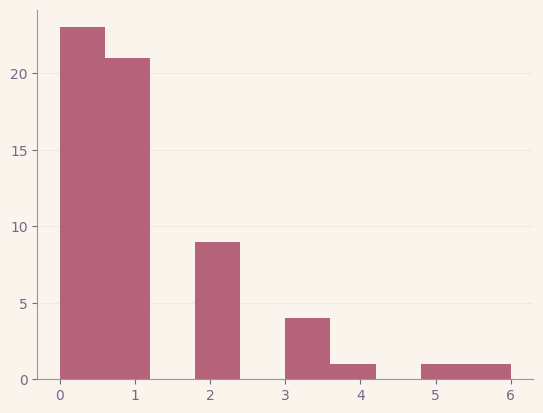

In [43]:
plt.hist(pos)

(array([23., 21.,  1.,  8.,  0.,  4.,  1.,  0.,  1.,  1.]),
 array([  0. ,  36.3,  72.6, 108.9, 145.2, 181.5, 217.8, 254.1, 290.4,
        326.7, 363. ]),
 <BarContainer object of 10 artists>)

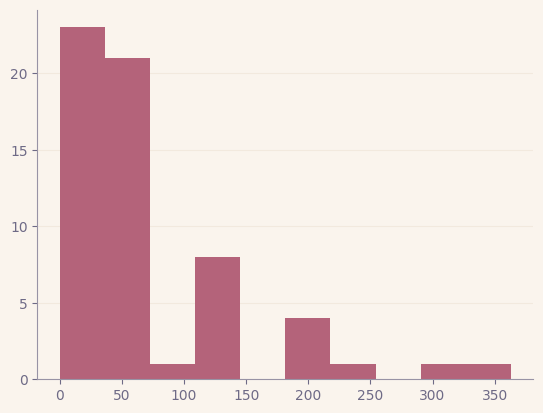

In [44]:
plt.hist(neg)

In [45]:
neg_counter = Counter(neg)
neg_counter

Counter({0: 23,
         63: 8,
         62: 4,
         58: 3,
         126: 3,
         125: 2,
         189: 2,
         186: 1,
         188: 1,
         115: 1,
         363: 1,
         59: 1,
         48: 1,
         52: 1,
         299: 1,
         111: 1,
         60: 1,
         101: 1,
         112: 1,
         249: 1,
         61: 1,
         51: 1})

In [19]:
def create_splits(pair_data, target_ratio=0.8, rng_seed=42, eps=0.05):
    random.seed(rng_seed)
    thm_names = list(pair_data.keys())
    _, counts = count_pairs(pair_data)
    total_size = sum(counts)
    thm_pairs = {thm_name: count for thm_name, count in zip(thm_names, counts)}
    random.shuffle(thm_names)
    target_size = target_ratio * total_size

    subset = set()
    complement = set(pair_data.keys())
    size = 0
    while size < (target_size * (1 - eps)):
        idx = len(subset)
        thm = thm_names[idx]
        size += thm_pairs[thm]
        subset.add(thm)
        complement.remove(thm)
    
    split1 = {k: pair_data[k] for k in subset}
    split2 = {k: pair_data[k] for k in complement}
    print(f"total size: {total_size}, target size: {target_size}, actual size: {(size, total_size - size)}")
    return split1, split2

In [20]:
train, test = create_splits(pair_data)

total size: 3987, target size: 3189.6000000000004, actual size: (3304, 683)


In [21]:
with open("../data/sampled_pairs_train_raw.json", 'w') as f:
    json.dump(train, f)
with open("../data/sampled_pairs_test_raw.json", 'w') as f:
    json.dump(test, f)

## Reformat data for DPO training

In [22]:
with open("../data/sampled_pairs_train_raw.json") as f:
    raw_train = json.load(f)
with open("../data/sampled_pairs_test_raw.json") as f:
    raw_test = json.load(f)

In [24]:
# Expected format: list[dict{'state': str, 'positive': str, 'negative': str}]
# DPO script converts this to an arrow DS with columns: prompt, chosen, rejected
def reformat_pair_data(pair_data, save_to_file=None):  
    reformatted = []
    for thm_dict in pair_data.values():
        if thm_dict is None:
            continue
        for state, (pos, negs) in thm_dict.items():
            for neg in negs:
                entry = {
                    "state": state,
                    "positive": pos,
                    "negative": neg,
                }
                reformatted.append(entry)

    if save_to_file:
        payload = {"pairs": reformatted}
        with open(save_to_file, 'w') as f:
            json.dump(payload, f)

    return reformatted

In [25]:
reformat_pair_data(train, "../data/sampled_pairs_train.json")
reformat_pair_data(test, "../data/sampled_pairs_test.json")

[{'state': "X : Type u\nY : Type v\nZ : Type w\nZ' : Type x\ninst✝³ : TopologicalSpace X\ninst✝² : TopologicalSpace Y\ninst✝¹ : TopologicalSpace Z\ninst✝ : TopologicalSpace Z'\nh : X ≃ₕ Y\n⊢ ↑h.toFun = ↑h",
  'positive': 'rfl',
  'negative': 'rcases h with ⟨x, rfl⟩'},
 {'state': "X : Type u\nY : Type v\nZ : Type w\nZ' : Type x\ninst✝³ : TopologicalSpace X\ninst✝² : TopologicalSpace Y\ninst✝¹ : TopologicalSpace Z\ninst✝ : TopologicalSpace Z'\nh : X ≃ₕ Y\n⊢ ↑h.toFun = ↑h",
  'positive': 'rfl',
  'negative': 'rcases h with ⟨h, rfl⟩'},
 {'state': "X : Type u\nY : Type v\nZ : Type w\nZ' : Type x\ninst✝³ : TopologicalSpace X\ninst✝² : TopologicalSpace Y\ninst✝¹ : TopologicalSpace Z\ninst✝ : TopologicalSpace Z'\nh : X ≃ₕ Y\n⊢ ↑h.toFun = ↑h",
  'positive': 'rfl',
  'negative': 'cases h'},
 {'state': "X : Type u\nY : Type v\nZ : Type w\nZ' : Type x\ninst✝³ : TopologicalSpace X\ninst✝² : TopologicalSpace Y\ninst✝¹ : TopologicalSpace Z\ninst✝ : TopologicalSpace Z'\nh : X ≃ₕ Y\n⊢ ↑h.toFun = ↑h",
 